In [1]:
from sklearn.datasets import make_classification
from train_model import train_network
import torch
import numpy as np
from matplotlib import pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
n_mosaic = 3000
K = 10
d = 4
n_classes = 5

In [3]:
x,y = make_classification(n_samples=500,n_features=d,n_informative=d,n_redundant=0,n_repeated= 0,n_classes=n_classes,n_clusters_per_class=1,flip_y=0.2,random_state=1234)   #D_4 random_state 1234


In [4]:
data = {'X':x,'Y':y}
np.save("data_2.npy",data)

In [5]:
# fg vs bg
y1 = np.zeros(y.shape,dtype=np.long)
indices = np.logical_or(y == 0,y==1) 
y1[indices] = 0
y1[np.logical_not(indices)] = 1

# fg1 vs fg2
index = np.logical_or(y==0,y==1)
x2 = x[index,:]
y2 = np.zeros(index.shape,dtype=np.long)
y2 = y[index]

In [6]:
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
from torch.utils.data import Dataset, DataLoader

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.linear1 = nn.Linear(d,2)
    # self.linear2 = nn.Linear(50,50)
    # self.linear3 = nn.Linear(50,50)
    # self.linear4 = nn.Linear(50,2)
  def forward(self,x):
    x = self.linear1(x)
    # x = F.relu(self.linear2(x))
    # x = F.relu(self.linear3(x))
    # x = F.relu(self.linear4(x))
    return x

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx]

batch = 250
# dataset = MosaicDataset(x2,y2)
# traindataloader = DataLoader( dataset,batch_size= batch ,shuffle=True)

In [9]:
dataset = MosaicDataset(x,y1)
traindataloader = DataLoader( dataset,batch_size= batch ,shuffle=True)
net = Net().double()
net =net.to(device)
train_model =train_network(net,traindataloader)
train_model.training(epochs=200,mini=1)



Training started...
[1,     1] loss: 1.010
[1,     2] loss: 0.958
[2,     1] loss: 1.007
[2,     2] loss: 0.912
[3,     1] loss: 0.824
[3,     2] loss: 1.006
[4,     1] loss: 0.876
[4,     2] loss: 0.851
[5,     1] loss: 0.812
[5,     2] loss: 0.793
[6,     1] loss: 0.764
[6,     2] loss: 0.723
[7,     1] loss: 0.722
[7,     2] loss: 0.655
[8,     1] loss: 0.679
[8,     2] loss: 0.598
[9,     1] loss: 0.601
[9,     2] loss: 0.593
[10,     1] loss: 0.520
[10,     2] loss: 0.608
[11,     1] loss: 0.531
[11,     2] loss: 0.545
[12,     1] loss: 0.503
[12,     2] loss: 0.532
[13,     1] loss: 0.518
[13,     2] loss: 0.491
[14,     1] loss: 0.506
[14,     2] loss: 0.482
[15,     1] loss: 0.490
[15,     2] loss: 0.483
[16,     1] loss: 0.495
[16,     2] loss: 0.468
[17,     1] loss: 0.443
[17,     2] loss: 0.512
[18,     1] loss: 0.505
[18,     2] loss: 0.443
[19,     1] loss: 0.452
[19,     2] loss: 0.491
[20,     1] loss: 0.468
[20,     2] loss: 0.471
[21,     1] loss: 0.490
[21,     2] lo

percentage accuracy:  0.802


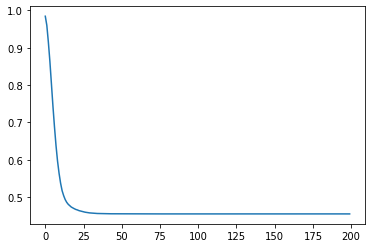

In [10]:
_,_=train_model.predict(traindataloader,True)
plt.plot(train_model.train_loss)

In [11]:
dataset = MosaicDataset(x2,y2)
traindataloader = DataLoader( dataset,batch_size= batch ,shuffle=True)
net = Net().double()
net =net.to(device)
train_model =train_network(net,traindataloader)
train_model.training(epochs=100,mini=1)



Training started...
[1,     1] loss: 1.192
[2,     1] loss: 1.173
[3,     1] loss: 1.137
[4,     1] loss: 1.087
[5,     1] loss: 1.026
[6,     1] loss: 0.958
[7,     1] loss: 0.886
[8,     1] loss: 0.814
[9,     1] loss: 0.745
[10,     1] loss: 0.681
[11,     1] loss: 0.624
[12,     1] loss: 0.575
[13,     1] loss: 0.534
[14,     1] loss: 0.500
[15,     1] loss: 0.472
[16,     1] loss: 0.450
[17,     1] loss: 0.433
[18,     1] loss: 0.419
[19,     1] loss: 0.408
[20,     1] loss: 0.399
[21,     1] loss: 0.392
[22,     1] loss: 0.386
[23,     1] loss: 0.381
[24,     1] loss: 0.378
[25,     1] loss: 0.374
[26,     1] loss: 0.372
[27,     1] loss: 0.369
[28,     1] loss: 0.367
[29,     1] loss: 0.365
[30,     1] loss: 0.363
[31,     1] loss: 0.361
[32,     1] loss: 0.360
[33,     1] loss: 0.358
[34,     1] loss: 0.357
[35,     1] loss: 0.355
[36,     1] loss: 0.354
[37,     1] loss: 0.353
[38,     1] loss: 0.352
[39,     1] loss: 0.350
[40,     1] loss: 0.349
[41,     1] loss: 0.348
[42, 

percentage accuracy:  0.898989898989899


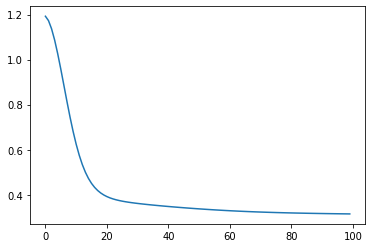

In [12]:
_,_=train_model.predict(traindataloader,True)
plt.plot(train_model.train_loss)

In [13]:
from plots import plot_analysis,focus_map,classification_map
from Models_Elemental import Focus_linear,Classification_linear
from Models_Elemental import Focus_deep,Classification_deep
from train_mosaic_new import train_mosaic_network

cpu


In [14]:
idx= []
for i in range(n_classes):
    print(i,sum(y==i))
    idx.append(y==i)

0 94
1 104
2 91
3 102
4 109


In [15]:
foreground_classes = {'class_0' ,'class_1'}

background_classes = {'class_2','class_3'}#,'class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [16]:

mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(n_mosaic):
    fg_class  = np.random.randint(0,len(foreground_classes))
    fg_idx = np.random.randint(0,K)
    a = []
    for i in range(K):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(len(foreground_classes),n_classes)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(d*K,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [17]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
mosaic_list.shape

(3000, 40)

In [18]:
np.unique(mosaic_label)

array([0, 1])

In [19]:
mosaic_data = {"X":mosaic_list,"Y":mosaic_label,"foreground_indices":fore_idx}
np.save("mosaic_data_4.npy",mosaic_data)

In [20]:
from sklearn.svm import SVC
sv = SVC(C=100,kernel="linear")
sv.fit(mosaic_list,mosaic_label)
print(sv.score(mosaic_list,mosaic_label))

0.6206666666666667


In [21]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [22]:
where = Focus_linear(d,1,K,d).double()
what = Classification_linear(d,2).double()

In [23]:
train_mosaic = train_mosaic_network(where,what,train_loader,elemental=False,lr=0.01)

In [24]:
train_mosaic.training(epochs=200,mini=3)

Training started...
[1,     3] loss: 0.791
[1,     6] loss: 0.764
[1,     9] loss: 0.728
[1,    12] loss: 0.684
[2,     3] loss: 0.684
[2,     6] loss: 0.684
[2,     9] loss: 0.667
[2,    12] loss: 0.674
[3,     3] loss: 0.677
[3,     6] loss: 0.671
[3,     9] loss: 0.670
[3,    12] loss: 0.662
[4,     3] loss: 0.665
[4,     6] loss: 0.650
[4,     9] loss: 0.654
[4,    12] loss: 0.652
[5,     3] loss: 0.641
[5,     6] loss: 0.644
[5,     9] loss: 0.639
[5,    12] loss: 0.637
[6,     3] loss: 0.624
[6,     6] loss: 0.628
[6,     9] loss: 0.644
[6,    12] loss: 0.606
[7,     3] loss: 0.638
[7,     6] loss: 0.596
[7,     9] loss: 0.616
[7,    12] loss: 0.606
[8,     3] loss: 0.602
[8,     6] loss: 0.623
[8,     9] loss: 0.606
[8,    12] loss: 0.592
[9,     3] loss: 0.598
[9,     6] loss: 0.594
[9,     9] loss: 0.612
[9,    12] loss: 0.594
[10,     3] loss: 0.589
[10,     6] loss: 0.606
[10,     9] loss: 0.589
[10,    12] loss: 0.596
[11,     3] loss: 0.603
[11,     6] loss: 0.571
[11,    

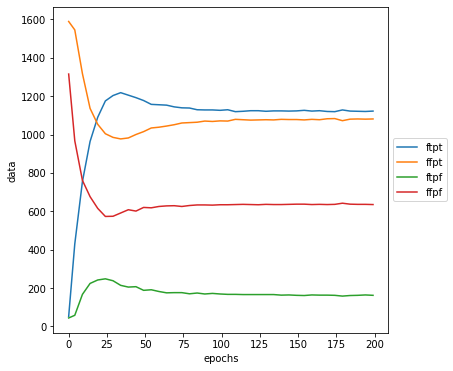

In [25]:
plot_analysis(np.array(train_mosaic.train_analysis))

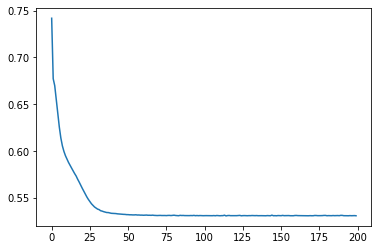

In [26]:
plt.plot(train_mosaic.train_loss)

In [27]:
_,_,_,_ = train_mosaic.predict(train_loader,True)

percentage accuracy:  0.7343333333333333


In [28]:
where_deep = Focus_deep(d,1,K,d).double()
what_deep = Classification_deep(d,2).double()

In [ ]:
train_mosaic_deep = train_mosaic_network(where_deep,what_deep,train_loader,elemental=False,lr =0.01)
train_mosaic_deep.training(epochs=700,mini=3)

Training started...
[1,     3] loss: 0.705
[1,     6] loss: 0.694
[1,     9] loss: 0.688
[1,    12] loss: 0.687
[2,     3] loss: 0.688
[2,     6] loss: 0.683
[2,     9] loss: 0.679
[2,    12] loss: 0.679
[3,     3] loss: 0.674
[3,     6] loss: 0.669
[3,     9] loss: 0.674
[3,    12] loss: 0.667
[4,     3] loss: 0.662
[4,     6] loss: 0.655
[4,     9] loss: 0.652
[4,    12] loss: 0.655
[5,     3] loss: 0.640
[5,     6] loss: 0.638
[5,     9] loss: 0.633
[5,    12] loss: 0.624
[6,     3] loss: 0.613
[6,     6] loss: 0.607
[6,     9] loss: 0.598
[6,    12] loss: 0.599
[7,     3] loss: 0.582
[7,     6] loss: 0.571
[7,     9] loss: 0.587
[7,    12] loss: 0.563
[8,     3] loss: 0.562
[8,     6] loss: 0.551
[8,     9] loss: 0.579
[8,    12] loss: 0.542
[9,     3] loss: 0.556
[9,     6] loss: 0.522
[9,     9] loss: 0.555
[9,    12] loss: 0.564
[10,     3] loss: 0.537
[10,     6] loss: 0.551
[10,     9] loss: 0.540
[10,    12] loss: 0.541
[11,     3] loss: 0.554
[11,     6] loss: 0.540
[11,    

In [ ]:
plot_analysis(np.array(train_mosaic_deep.train_analysis))

In [ ]:
plt.plot(train_mosaic_deep.train_loss)

In [ ]:
_,_,_,_ = train_mosaic_deep.predict(train_loader,True)